https://machinelearningmastery.com/lstm-autoencoders/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. MinMax scalar
2. Different loss functions
3. How to take output of encoder part

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer, MinMaxScaler
import tensorflow as tf

plt.rcParams["figure.figsize"] = [16,9]

In [15]:
!pip install -U umap-learn
import umap

Requirement already up-to-date: umap-learn in /usr/local/lib/python3.7/dist-packages (0.5.1)


In [16]:
!pip install -U keras-tuner
import kerastuner as kt

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [47]:
# _initializing constant variables

input_file_path_train = f'/content/drive/MyDrive/Colab Notebooks/processed_data_train.csv'
output_filename_features_train = f'UCIHAR_sensor_features_lstm_tuned_train.csv'
output_filename_activity_train = f'activity_subject_data_train.csv'

input_file_path_test = f'/content/drive/MyDrive/Colab Notebooks/processed_data_test.csv'
output_filename_features_test = f'UCIHAR_sensor_features_lstm_tuned_test.csv'
output_filename_activity_test = f'activity_subject_data_test.csv'

col_names = ['subject_id', 'activityID', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
main_df_train = pd.read_csv(input_file_path_train, names=col_names)
main_df_test = pd.read_csv(input_file_path_test, names=col_names)

1 WALKING

2 WALKING_UPSTAIRS

3 WALKING_DOWNSTAIRS

4 SITTING

5 STANDING

6 LAYING


In [48]:
sensor_data_train = main_df_train.iloc[:, 2:].values.astype('float32')
print(sensor_data_train.shape)

(941056, 6)


In [49]:
sensor_data_test = main_df_test.iloc[:, 2:].values.astype('float32')
print(sensor_data_test.shape)

(377216, 6)


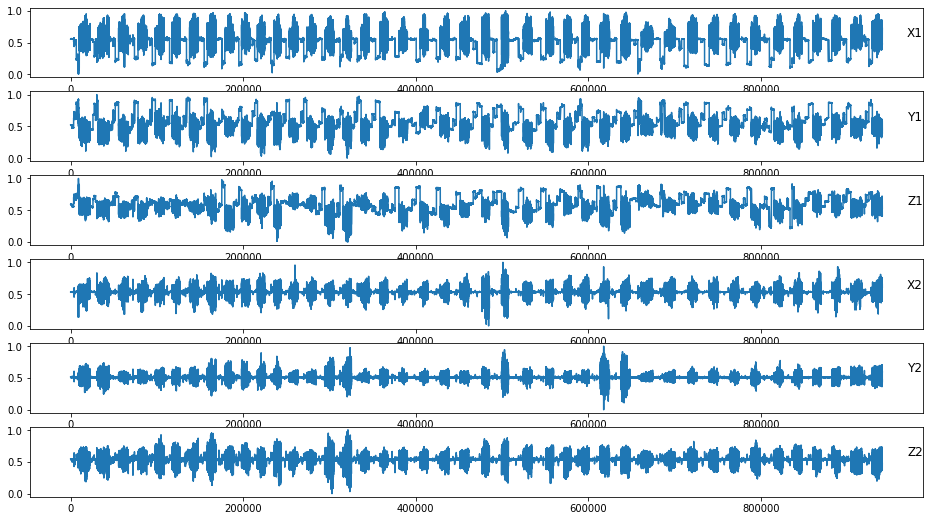

In [50]:
sensor_data_train = MinMaxScaler().fit_transform(sensor_data_train)
sensor_data_test = MinMaxScaler().fit_transform(sensor_data_test)

plt.figure()
for col in range(6):
	plt.subplot(6, 1, col+1)
	plt.plot(sensor_data_train[:, col])
	plt.title(col_names[col+2], y=0.5, loc='right')

plt.show()

In [51]:
window_size = 32
window_overlap = 24
timesteps = window_size
max_window_index = 128
features = 6

In [52]:
def get_window_data(instance_data):

  instance_data = instance_data.reshape(6, 128)
  window_index = 0
  sub_sequences = [[] for i in range(6)]

  while window_index <= (max_window_index - window_size):

      for idx in range(6):
          sub_sequences[idx].append(instance_data[idx][window_index:window_index+window_size].tolist())

      window_index += window_overlap

  sub_sequences = np.array(sub_sequences).reshape(-1, 6, window_size)
  return sub_sequences

In [53]:
def get_sensor_sequences(main_df):

  activity_subject_df = main_df[['activityID', 'subject_id']].drop_duplicates().values.astype('int32')
  activity_sequences = []
  sensor_sequences = np.array([])

  for instance in activity_subject_df:
    activity = instance[0]
    subject = instance[1]
    instance_data = main_df.loc[(main_df['subject_id'] == subject) & (main_df['activityID'] == activity)]
    subsequence_data = get_window_data(instance_data[col_names[2:]].values)

    for val in range(subsequence_data.shape[0]):
      activity_sequences.append([subject, activity])

    if sensor_sequences.size == 0:
      sensor_sequences = subsequence_data
    else:
      sensor_sequences = np.vstack((sensor_sequences, subsequence_data))  

  return sensor_sequences, np.array(activity_sequences)

In [54]:
sensor_sequences_train, activity_sequences_train  = get_sensor_sequences(main_df_train)
sensor_sequences_test, activity_sequences_test = get_sensor_sequences(main_df_test)

In [55]:
assert activity_sequences_train.shape[0] == sensor_sequences_train.shape[0]
sensor_sequences_train.shape

(36760, 6, 32)

In [56]:
assert activity_sequences_test.shape[0] == sensor_sequences_test.shape[0]
sensor_sequences_test.shape

(14735, 6, 32)

In [57]:
# _input data format - [samples, timesteps, features]
def get_sensor_data(sensor_sequences):
  features = 1
  sensor_data = sensor_sequences[:, 0]
  sensor_data = sensor_data.reshape(-1, timesteps, features)

  for col in range(1, 6):
    sensor_data_channel = sensor_sequences[:, col]
    sensor_data_channel = sensor_data_channel.reshape(-1, timesteps, features)

    sensor_data = np.vstack((sensor_data, sensor_data_channel))  
    
  return sensor_data

In [58]:
sensor_data_train = get_sensor_data(sensor_sequences_train)
sensor_data_train.shape

(220560, 32, 1)

In [59]:
sensor_data_test = get_sensor_data(sensor_sequences_test)
sensor_data_test.shape

(88410, 32, 1)

In [60]:
sensor_data = np.vstack((sensor_data_train, sensor_data_test))  
sensor_data.shape

(308970, 32, 1)

In [61]:
features = 1

In [62]:
def build_model(hp):

    lstm_layer_1_output_params = hp.Int(
        'output_1', min_value=80, max_value=120, step=5)
    lstm_layer_2_output_params = hp.Int(
        'output_2', min_value=50, max_value=80, step=5)
    
    lstm_layer_1_dropoutrate_params = hp.Float(
        'dropoutrate_1', min_value=0.2, max_value=0.6, step=0.1)
    lstm_layer_2_dropoutrate_params = hp.Float(
        'dropoutrate_2', min_value=0.2, max_value=0.6, step=0.1)

    activation_fn_params = hp.Choice(
        'act_fn', values=['relu', 'tanh'])

    learning_rate_params = hp.Choice(
        'learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, input_shape=(timesteps, features), return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=False),
        tf.keras.layers.Dropout(rate=lstm_layer_1_dropoutrate_params),

        tf.keras.layers.RepeatVector(timesteps),

        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.Dropout(rate=lstm_layer_2_dropoutrate_params),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_params),loss='mse')

    return model

In [63]:
tuner_bo = kt.tuners.BayesianOptimization(
                build_model,objective=kt.Objective('val_loss', direction="min"), max_trials = 10, executions_per_trial=2
)

# tuner_bo.search(sensor_data, sensor_data, epochs=3, batch_size=64 ,validation_split=0.3)
# best_model = tuner_bo.get_best_models(num_models=1)[0]
# print(best_model.summary()) 

# best_hp = tuner_bo.get_best_hyperparameters()[0]
# print(best_hp.values)

In [64]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

#history = best_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

In [65]:
lstm_ae_model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(90, activation='tanh', input_shape=(timesteps, features), return_sequences=True),
     tf.keras.layers.LSTM(45, activation='tanh', return_sequences=False),
     tf.keras.layers.Dropout(rate=0.3),

     tf.keras.layers.RepeatVector(timesteps),

     tf.keras.layers.LSTM(45, activation='tanh', return_sequences=True),
     tf.keras.layers.LSTM(90, activation='tanh', return_sequences=True),
     tf.keras.layers.Dropout(rate=0.5),

     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
 ])
lstm_ae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
lstm_ae_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32, 90)            33120     
_________________________________________________________________
lstm_5 (LSTM)                (None, 45)                24480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 45)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 32, 45)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 45)            16380     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32, 90)            48960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 90)           

In [66]:
history = lstm_ae_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.2, callbacks=[early_stopping], batch_size=64)
best_model = lstm_ae_model

Epoch 1/50
3863/3863 [==============================] - 49s 12ms/step - loss: 0.2984 - val_loss: 0.1365
Epoch 2/50
3863/3863 [==============================] - 43s 11ms/step - loss: 0.1449 - val_loss: 0.1199
Epoch 3/50
3863/3863 [==============================] - 43s 11ms/step - loss: 0.1281 - val_loss: 0.0965
Epoch 4/50
3863/3863 [==============================] - 44s 11ms/step - loss: 0.1104 - val_loss: 0.0729
Epoch 5/50
3863/3863 [==============================] - 44s 11ms/step - loss: 0.0995 - val_loss: 0.0689
Epoch 6/50
3863/3863 [==============================] - 43s 11ms/step - loss: 0.0947 - val_loss: 0.0635
Epoch 7/50
3863/3863 [==============================] - 43s 11ms/step - loss: 0.0891 - val_loss: 0.0558
Epoch 8/50
3863/3863 [==============================] - 44s 11ms/step - loss: 0.0865 - val_loss: 0.0777
Epoch 9/50
3863/3863 [==============================] - 43s 11ms/step - loss: 0.0987 - val_loss: 0.0533
Epoch 10/50
3863/3863 [==============================] - 43s 11m

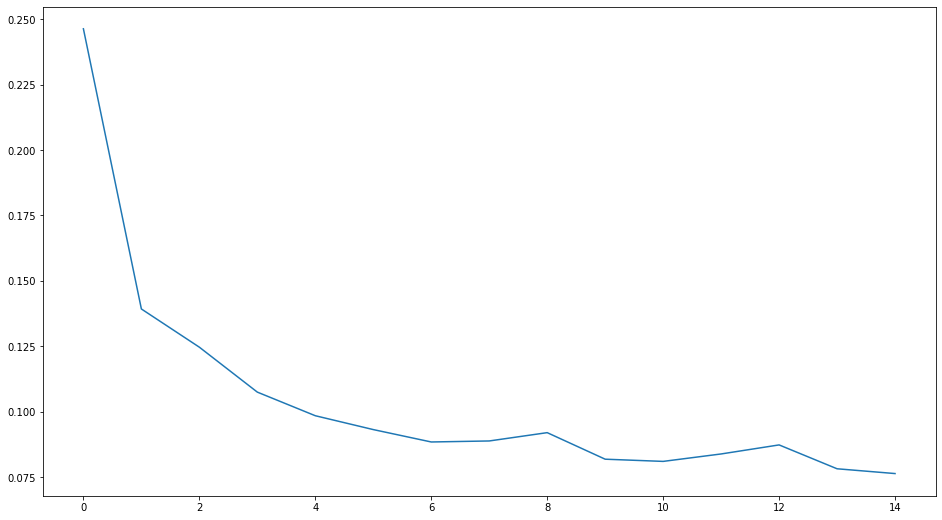

In [67]:
plt.plot(history.history['loss'])
plt.show()

In [68]:
sensor_data.shape

(308970, 32, 1)

In [69]:
get_2rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[2].output])

In [70]:
def get_umap_data(data):
    
    data = MinMaxScaler().fit_transform(data)
    model_umap = umap.UMAP(n_neighbors = 10, min_dist = 0.1, n_components = 4)
    umap_vec = model_umap.fit_transform(data)

    return umap_vec

In [71]:
def get_final_features(sensor_sequences):
  final_features = None
  for col in range(6):
    sensor_data_channel = sensor_sequences[:, col]
    sensor_data_channel = sensor_data_channel.reshape(-1, timesteps, features)

    encoder_output = get_2rd_layer_output(sensor_data_channel)
    sensor_features = np.asarray(encoder_output).astype('float32')

    sensor_features = sensor_features.reshape(sensor_features.shape[1], sensor_features.shape[2])
    if final_features is None:
      final_features = sensor_features
    else:
      final_features = np.vstack((final_features, sensor_features))  

    print(sensor_features.shape)

  return final_features

In [72]:
final_features_train = get_final_features(sensor_sequences_train)
final_features_train.shape

(36760, 45)
(36760, 45)
(36760, 45)
(36760, 45)
(36760, 45)
(36760, 45)


(220560, 45)

In [73]:
final_features_test = get_final_features(sensor_sequences_test)
final_features_test.shape

(14735, 45)
(14735, 45)
(14735, 45)
(14735, 45)
(14735, 45)
(14735, 45)


(88410, 45)

In [74]:
def write_output_file(file_name, data):
  np.savetxt(file_name, data, delimiter=",")

In [75]:
write_output_file(output_filename_features_train, final_features_train)
write_output_file(output_filename_features_test, final_features_test)
write_output_file(output_filename_activity_train, activity_sequences_train)
write_output_file(output_filename_activity_test, activity_sequences_test)

In [76]:
!cp *.csv 'drive/MyDrive/lstm_data/'